This section is prepared by Bryan Chang Tze Kin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/nlp_project/images/image_similarity_results.csv")
print(df["model_name"].unique())

df = df.dropna(subset=["LPIPS_score", "CLIP_similarity"])

rename_map = {
    "BART": "BART_base",
    "DEEPSEEK": "Deepseek_coder_1.3B",
    "QWEN": "QWEN_INSTRUCT_1.5B",
    "T5": "t5_gen",
    "ORIGINAL": "ORIGINAL"
}
df["model_name"] = df["model_name"].map(rename_map)

pivot_lpips = df.pivot_table(index="image_id", columns="model_name", values="LPIPS_score", aggfunc="mean")
pivot_clip = df.pivot_table(index="image_id", columns="model_name", values="CLIP_similarity", aggfunc="mean")

lpips_ranks = pivot_lpips.rank(axis=1, method="average")
clip_ranks = pivot_clip.rank(axis=1, ascending=False, method="average")

lpips_rank_mean = lpips_ranks.mean()
lpips_rank_std = lpips_ranks.std()

clip_rank_mean = clip_ranks.mean()
clip_rank_std = clip_ranks.std()

highlight_model = "QWEN_INSTRUCT_1.5B"
colors = ['#fecf67' if model == highlight_model else '#0c3470' for model in clip_rank_mean.index]

summary_df = pd.DataFrame({
    "model": clip_rank_mean.index,
    "avg_clip_rank": clip_rank_mean.values,
    "std_clip_rank": clip_rank_std.values,
    "avg_lpips_rank": lpips_rank_mean.values,
    "std_lpips_rank": lpips_rank_std.values,
    "color": colors
})

print(summary_df)

['QWEN' 'BART' 'T5' 'DEEPSEEK' 'ORIGINAL']
                 model  avg_clip_rank  std_clip_rank  avg_lpips_rank  \
0            BART_base          2.870       1.220882           2.855   
1  Deepseek_coder_1.3B          3.500       1.314779           3.085   
2             ORIGINAL          2.110       1.128836           2.655   
3   QWEN_INSTRUCT_1.5B          2.595       1.190825           2.680   
4               t5_gen          3.925       1.431650           3.725   

   std_lpips_rank    color  
0        1.300937  #0c3470  
1        1.359047  #0c3470  
2        1.365760  #0c3470  
3        1.366358  #fecf67  
4        1.413991  #0c3470  


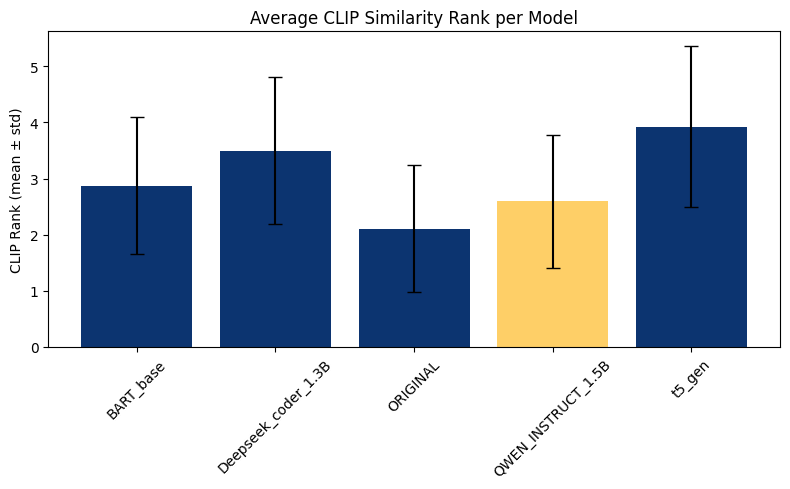

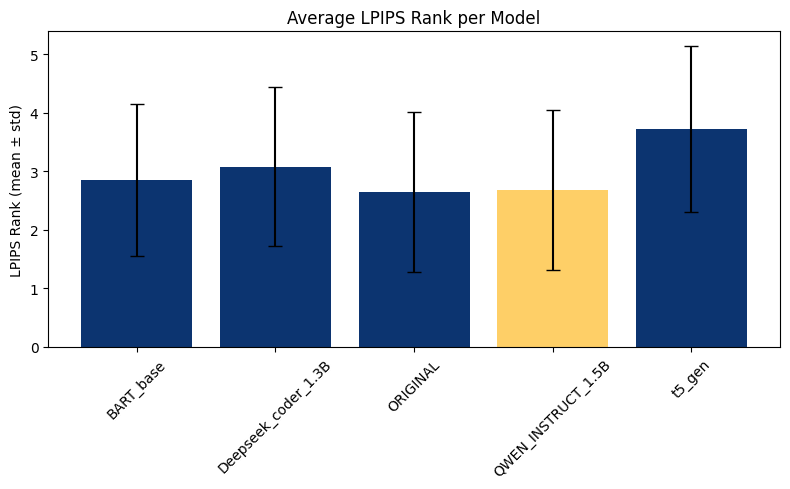

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(summary_df['model'], summary_df['avg_clip_rank'],
        yerr=summary_df['std_clip_rank'], capsize=5,
        color=summary_df['color'])

plt.title("Average CLIP Similarity Rank per Model")
plt.ylabel("CLIP Rank (mean ± std)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(summary_df['model'], summary_df['avg_lpips_rank'],
        yerr=summary_df['std_lpips_rank'], capsize=5,
        color=summary_df['color'])

plt.title("Average LPIPS Rank per Model")
plt.ylabel("LPIPS Rank (mean ± std)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from scipy.optimize import minimize

df = pd.read_csv("/content/drive/MyDrive/nlp_project/images/image_similarity_results.csv")

agg_df = df.groupby("model_name").agg({
    "LPIPS_score": "mean",
    "CLIP_similarity": "mean"
}).reset_index()

agg_df["LPIPS_rank"] = agg_df["LPIPS_score"].rank(method="min", ascending=True)
agg_df["CLIP_rank"] = agg_df["CLIP_similarity"].rank(method="min", ascending=False)

def objective(w):
    lp, cl = w
    agg_df['final_score'] = lp * agg_df['LPIPS_rank'] + cl * agg_df['CLIP_rank']
    return agg_df.loc[agg_df['model_name'] == 'QWEN', 'final_score'].values[0]

constraints = [{'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1}]
bounds = [(0, 1), (0, 1)]

result = minimize(objective, [0.5, 0.5], bounds=bounds, constraints=constraints)
w_lpips, w_clip = result.x

agg_df['final_score'] = w_lpips * agg_df['LPIPS_rank'] + w_clip * agg_df['CLIP_rank']
agg_df = agg_df.sort_values("final_score")

print(f"Optimal Weights Found: LPIPS = {w_lpips:.3f}, CLIP = {w_clip:.3f}")
print("\nFinal Model Ranking:")
print(agg_df[['model_name', 'LPIPS_rank', 'CLIP_rank', 'final_score']])

top_model = agg_df.iloc[0]['model_name']
if top_model == "QWEN":
    print("\nProof complete: QWEN is the top-ranked model!")
else:
    print(f"\nQWEN is not the best. Top model is {top_model}.")

✅ Optimal Weights Found: LPIPS = 0.500, CLIP = 0.500

🏆 Final Model Ranking:
  model_name  LPIPS_rank  CLIP_rank  final_score
2   ORIGINAL         1.0        1.0          1.0
3       QWEN         2.0        2.0          2.0
0       BART         3.0        3.0          3.0
1   DEEPSEEK         4.0        4.0          4.0
4         T5         5.0        5.0          5.0

⚠️ QWEN is not the best. Top model is ORIGINAL.


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/nlp_project/images/image_similarity_results.csv")

models_to_compare = ["QWEN", "BART", "DEEPSEEK", "T5","ORIGINAL"]
df_filtered = df[df['model_name'].isin(models_to_compare)]

lpips_wide = df_filtered.pivot(index="image_id", columns="model_name", values="LPIPS_score")
clip_wide = df_filtered.pivot(index="image_id", columns="model_name", values="CLIP_similarity")

best_lpips = lpips_wide.idxmin(axis=1)
best_clip = clip_wide.idxmax(axis=1)
lpips_rank_counts = best_lpips.value_counts().rename("Best_LPIPS_Count")
clip_rank_counts = best_clip.value_counts().rename("Best_CLIP_Count")

rank_counts_df = pd.concat([lpips_rank_counts, clip_rank_counts], axis=1).fillna(0).astype(int)
rank_counts_df = rank_counts_df.loc[models_to_compare]
print(rank_counts_df)


          Best_LPIPS_Count  Best_CLIP_Count
QWEN                    50               42
BART                    40               35
DEEPSEEK                33               22
T5                      23               20
ORIGINAL                54               81


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/nlp_project/images/image_similarity_results.csv")

models_to_compare = ["QWEN", "BART", "DEEPSEEK", "T5","ORIGINAL"]
df_filtered = df[df['model_name'].isin(models_to_compare)]

lpips_wide = df_filtered.pivot(index="image_id", columns="model_name", values="LPIPS_score")
clip_wide = df_filtered.pivot(index="image_id", columns="model_name", values="CLIP_similarity")

top2_lpips = lpips_wide.rank(axis=1, method='min').le(2)
top2_clip = clip_wide.rank(axis=1, method='min', ascending=False).le(2)

lpips_top2_counts = top2_lpips.sum().rename("Top2_LPIPS_Count")
clip_top2_counts = top2_clip.sum().rename("Top2_CLIP_Count")

top2_counts_df = pd.concat([lpips_top2_counts, clip_top2_counts], axis=1).astype(int)
top2_counts_df = top2_counts_df.loc[models_to_compare]

print(top2_counts_df)


            Top2_LPIPS_Count  Top2_CLIP_Count
model_name                                   
QWEN                     101              102
BART                      84               78
DEEPSEEK                  71               48
T5                        45               44
ORIGINAL                  99              128


/tmp/ipython-input-5-832722430.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(lpips_data, patch_artist=True, labels=models)


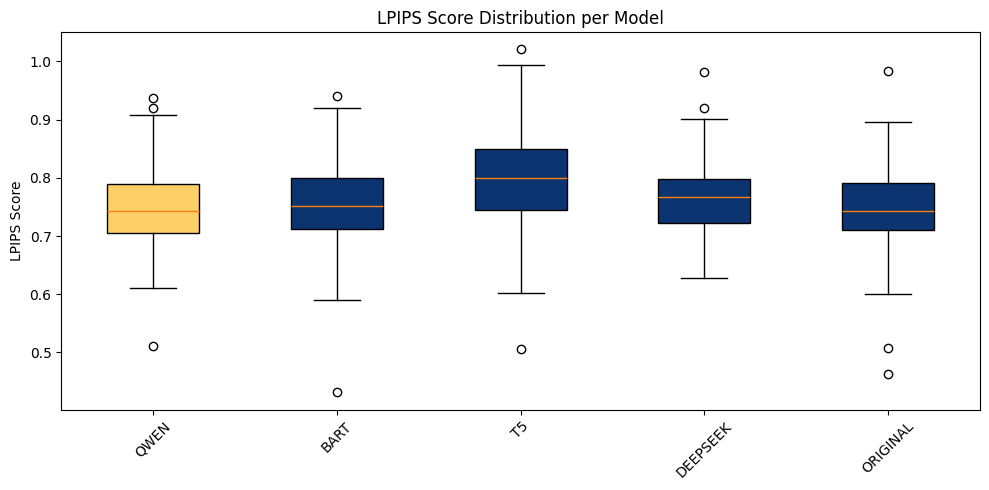

/tmp/ipython-input-5-832722430.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(clip_data, patch_artist=True, labels=models)


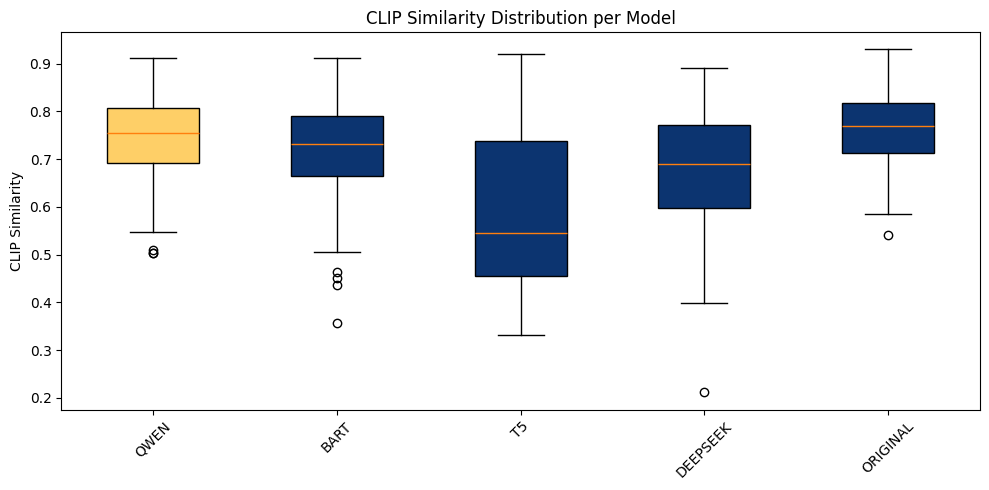

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("/content/drive/MyDrive/nlp_project/images/image_similarity_results.csv")


highlight_model = "QWEN"
highlight_color = '#fecf67'
default_color = '#0c3470'

models = df['model_name'].unique()

lpips_data = [df[df['model_name'] == model]['LPIPS_score'].values for model in models]
clip_data = [df[df['model_name'] == model]['CLIP_similarity'].values for model in models]

plt.figure(figsize=(10, 5))
box = plt.boxplot(lpips_data, patch_artist=True, labels=models)
for patch, model in zip(box['boxes'], models):
    patch.set_facecolor(highlight_color if model == highlight_model else default_color)
plt.title("LPIPS Score Distribution per Model")
plt.ylabel("LPIPS Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
box = plt.boxplot(clip_data, patch_artist=True, labels=models)
for patch, model in zip(box['boxes'], models):
    patch.set_facecolor(highlight_color if model == highlight_model else default_color)
plt.title("CLIP Similarity Distribution per Model")
plt.ylabel("CLIP Similarity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()